In [4]:
using LaTeXStrings
using StatsPlots
using PrettyTables
pyplot()
using StatsBase
using Corpuscles
using UnicodeFun
using FastJet
using CxxWrap: StdVector
using LCIO
using LinearAlgebra
#gr()
#theme(:gruvbox_dark)

In [7]:
#using Pkg; Pkg.build("FastJet")
#using Pkg; Pkg.build("LCIO")

Set A: 
Processes: Pmumuh2bb, Pmumuh2cc, Pmumuh2gg
"0_DST" > ".*_DST"

In [8]:
function jetConstituentP(constituent)
    a=FastJet.px(constituent)::Float64
    b=FastJet.py(constituent)::Float64
    c=FastJet.pz(constituent)::Float64
    return (a,b,c)
end

function leadingParticleIndex(jet)
    momentumList = []
    highestMomentum = 0
    nCon = 0
    index = 0
    for c in constituents(jet)
        nCon+=1
        p=jetConstituentP(c)
        if dot(p, p)>highestMomentum
            highestMomentum=dot(p, p)
            index=nCon
        end
    end
    return index
end

function invMassSum(particle_1, particle_2)
    a = sqrt((getEnergy(particle_1)+getEnergy(particle_2))^2-
        dot(getMomentum(particle_1)+getMomentum(particle_2),
            getMomentum(particle_1)+getMomentum(particle_2)))
    return a
end

#can use a sort function where the key to sort on is dot(p, p)

invMassSum (generic function with 1 method)

In [9]:
fileList_ss = filter(s->occursin(r"E250_SetA.Pmumuh2ss.Gwhizard-2_84.eL0.8\.pR0.3\..*_DST.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel", join=true))

fileList_bb = filter(s->occursin(r"E250_SetA.Pmumuh2bb.Gwhizard-2_84.eL0.8\.pR0.3\..*_DST.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel", join=true))

fileList_cc = filter(s->occursin(r"E250_SetA.Pmumuh2cc.Gwhizard-2_84.eL0.8\.pR0.3\..*_DST.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel", join=true))

fileList_gg = filter(s->occursin(r"E250_SetA.Pmumuh2gg.Gwhizard-2_84.eL0.8\.pR0.3\..*_DST.slcio", s), readdir("/nfs/dust/ilc/user/jstrube/StrangeHiggs/data/RecoLevel", join=true))

print("ss has ")
print(length(fileList_ss))
print(" files, bb has ")
print(length(fileList_bb))
print(" files, cc has ")
print(length(fileList_cc))
print(" files, gg has ")
print(length(fileList_gg))
print(" files")

ss has 100 files, bb has 100 files, cc has 100 files, gg has 100 files

In [10]:
sampleList=[fileList_ss, fileList_bb, fileList_cc, fileList_gg]
nFile=[]
nEvent=[]
for sample in sampleList
    iFile=0
    iEvent=0
    for FILENAME in sample
        iFile+=1
        LCIO.open(FILENAME) do reader
            for event in reader
                iEv  ent+=1
            end
        end  
    end
    push!(nEvent, iEvent)
    push!(nFile, iFile)
end
print(nFile)
print(" ")
print(nEvent)

LoadError: syntax: extra token "ent" after end of expression

Strange Events

In [11]:
LCIO.open(fileList_ss[1]) do reader
    for (iEvent, event) in enumerate(reader)
        for name in getCollectionNames(event)
            println(name)
        end
        break
    end
end

BuildUpVertices
BuildUpVertices_RP
BuildUpVertices_V0
BuildUpVertices_V0_RP
BuildUpVertices_V0_res
BuildUpVertices_V0_res_RP
BuildUpVertices_res
BuildUpVertices_res_RP
ECalBarrelHits
ECalEndcapHits
MCParticle
PandoraClusters
PandoraPFANewStartVertices
PandoraPFOs
PrimaryVertices
PrimaryVertices_RP
PrimaryVertices_res
PrimaryVertices_res_RP
RecoMCTruthLink
RefinedVertexJets
RefinedVertexJets_rel
RefinedVertexJets_vtx
RefinedVertexJets_vtx_RP
RefinedVertices
RefinedVertices_RP
VertexJets


In [12]:
ss_MCleadPDG = []
ss_MCleadingParticlePList = []
ss_PFOleadPDG = []
ss_PFOleadingParticlePList = []
ss_kShortInPiPiEventList_MC = []
ss_kShortInPiPiEventList_PFO = []
ss_lambdaInProtonEventList_MC = []
ss_lambdaInProtonEventList_PFO = []

vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)

for FILENAME in fileList_ss
    LCIO.open(FILENAME) do reader
        for (iEvent, event) in enumerate(reader)
            
            #recoLinks = getCollection(event, "RecoMCTruthLink")
            
            #This is the Jet Clustering Loop for MCParticles
            mcp = getCollection(event, "MCParticle")
            iMCParticle = 0
            MCparticles = PseudoJet[]
            for MCparticle in mcp
                iMCParticle += 1
                if getGeneratorStatus(MCparticle) != 1
                    continue
                end
                E = getEnergy(MCparticle)
                p = getMomentum(MCparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iMCParticle)
                push!(MCparticles, pj)
            end
            MCcs = ClusterSequence(StdVector(MCparticles), jet_def)
            MCjets = exclusive_jets(MCcs, 2)
            nMCJet=0
            for j in MCjets
                nMCJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        MCParticle = mcp[index]
                        pdg=getPDG(MCParticle)
                        if abs(pdg)==13
                            continue
                        end
                        if abs(pdg)==211
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==130
                                    push!(ss_kShortInPiPiEventList_MC, iEvent)
                                end
                            end
                        end
                        if abs(pdg)==2212
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==3312
                                    push!(ss_lambdaInProtonEventList_MC, iEvent)
                                end
                            end
                        end
                        push!(ss_MCleadPDG, pdg)
                    end
                end
            end
            if FastJet.n_particles(MCcs)<0
                print("你好！")
            end
            #reconstructed particle loop
            rp = getCollection(event, "PandoraPFOs")
            recoLinks = getCollection(event, "RecoMCTruthLink")
            rel=LCIO.LCRelationNavigator(recoLinks)
            iRPParticle = 0
            #大家好，如果你会读懂，我想告诉你很重要的事：加油！
            RPparticles = PseudoJet[]
            for RPparticle in rp
                iRPParticle += 1
                #if getGeneratorStatus(RPparticle) != 1
                #    continue
                #end
                E = getEnergy(RPparticle)
                p = getMomentum(RPparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iRPParticle)
                push!(RPparticles, pj)
            end
            RPcs = ClusterSequence(StdVector(RPparticles), jet_def)
            RPjets = exclusive_jets(RPcs, 2)
            nRPJet=0
            for j in RPjets
                nRPJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        RP = rp[index]
                        mcpList = getRelatedToObjects(rel, RP)
                        if length(mcpList)>0
                            pdg=getPDG(mcpList[1])
                            if abs(pdg)==13
                                continue
                            end
                            if abs(pdg)==211
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==130
                                        push!(ss_kShortInPiPiEventList_PFO, iEvent)
                                    end
                                end
                            end
                            push!(ss_PFOleadPDG, pdg)
                            if abs(pdg)==2212
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==3312
                                        push!(ss_lambdaInProtonEventList_PFO, iEvent)
                                    end
                                end
                            end
                        end
                        #invMassRP = sqrt(getEnergy(RP)^2+leadMomentum^2)
                        #push!(PFOleadPDG, invMassRP)
                    end
                end
            end
            if FastJet.n_particles(RPcs)<0
                print("你好！")
            end
        end
    end
end

#--------------------------------------------------------------------------
#                         FastJet release 3.3.4
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code
# and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


Produce figure with MC Particle and Pandora PFO breakdown for all 4 event types\
-Remove muon from everything\
-2 jets\
-Check if theres a K short in the pi pi highest particle events\
-If proton, check if lambda 0\
-just make a dictionary where name maps to value\
Run Z reco over MCParticle & PandoraPFO, compare

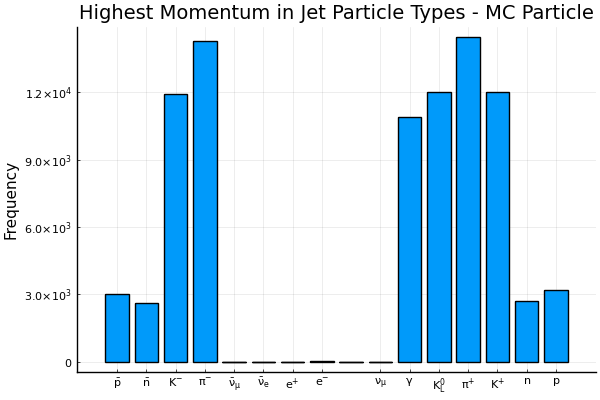

In [13]:
ss_MC_y=ss_MCleadPDG
ss_MC_u=sort(unique(ss_MC_y))
ss_MC_d=Dict([(i,count(x->x==i,ss_MC_y)) for i in ss_MC_u])
ss_MC_vals = [ss_MC_d[i] for i in ss_MC_u]
ss_MC_Names=[]
for key in ss_MC_u
    push!(ss_MC_Names, latexstring(Particle(convert(Int64, key)).latex))
end
StatsPlots.bar(ss_MC_Names, ss_MC_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - MC Particle", legend=false)
#print(latex)
#print(to_latex(printed_latex[1]))
#print(edit_latex)
#print(numbers)
#numbers = ["$(ss_MC_u[i])" for i in 1:length(ss_MC_u)]

#StatsPlots.savefig("ss_MCleadParticle.pdf")
#Names = Dict(-11 => "e^{+}",211 => "\\pi^{+}",11 => "e^{-}",2212 => "p",-2212 => "p",-211 => "\\pi^{-}",130 => "K_{l}^{0}",321 => "K^{+}",22 => "\\gamma",2112 => "n",-321 => "K^{-}",-2112 => "\\barn",-13 => "\\mu^{+}", 13 => "\\mu^{-}",-14 => "\\overbarv_{u}")

Any[L"$\bar{\Omega}^{+}$", L"$\bar{\Xi}^{0}$", L"$\bar{\Xi}^{+}$", L"$\bar{\Sigma}^{-}$", L"$\bar{\Lambda}$", L"$\bar{\Sigma}^{+}$", L"$\bar{p}$", L"$\bar{n}$", L"$K^{-}$", L"$\pi^{-}$", L"$e^{+}$", L"$e^{-}$", L"$\gamma$", L"$a_{2}(1320)^{0}$", L"$K_{L}^{0}$", L"$\pi^{+}$", L"$K_{S}^{0}$", L"$K^{+}$", L"$n$", L"$p$", L"$\Sigma^{-}$", L"$\Lambda$", L"$\Sigma^{+}$", L"$\Xi^{-}$", L"$\Xi^{0}$", L"$\Omega^{-}$"]

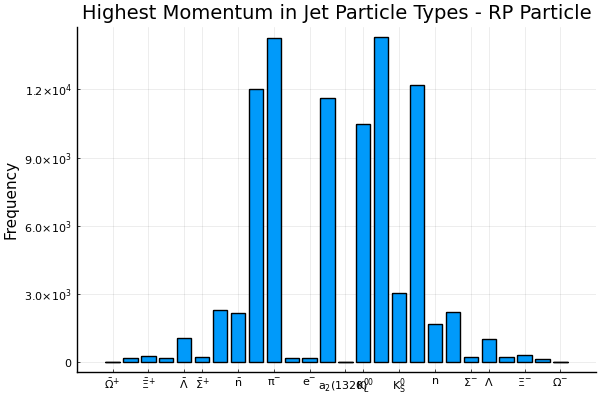

In [14]:
ss_RP_y=ss_PFOleadPDG
ss_RP_u=sort(unique(ss_RP_y))
ss_RP_d=Dict([(i,count(x->x==i,ss_RP_y)) for i in ss_RP_u])
ss_RP_vals = [ss_RP_d[i] for i in ss_RP_u]
ss_RP_Names=[]
for key in ss_RP_u
    push!(ss_RP_Names, latexstring(Particle(convert(Int64, key)).latex))
end
print(ss_RP_Names)
StatsPlots.bar(ss_RP_Names, ss_RP_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - RP Particle", legend=false)
#print(ss_RP_latex)
#print(to_latex(printed_latex[1]))
#print(edit_latex)
#print(numbers)
#numbers = ["$(ss_RP_u[i])" for i in 1:length(ss_RP_u)]

#StatsPlots.savefig("ss_RPleadParticle.pdf")
#Names = Dict(-11 => "e^{+}",211 => "\\pi^{+}",11 => "e^{-}",2212 => "p",-2212 => "p",-211 => "\\pi^{-}",130 => "K_{l}^{0}",321 => "K^{+}",22 => "\\gamma",2112 => "n",-321 => "K^{-}",-2112 => "\\barn",-13 => "\\mu^{+}", 13 => "\\mu^{-}",-14 => "\\overbarv_{u}")

Same code, botton events

In [15]:
LCIO.open(fileList_bb[1]) do reader
    for (iEvent, event) in enumerate(reader)
        for name in getCollectionNames(event)
            println(name)
        end
        break
    end
end

BuildUpVertices
BuildUpVertices_RP
BuildUpVertices_V0
BuildUpVertices_V0_RP
BuildUpVertices_V0_res
BuildUpVertices_V0_res_RP
BuildUpVertices_res
BuildUpVertices_res_RP
ECalBarrelHits
ECalEndcapHits
MCParticle
PandoraClusters
PandoraPFANewStartVertices
PandoraPFOs
PrimaryVertices
PrimaryVertices_RP
PrimaryVertices_res
PrimaryVertices_res_RP
RecoMCTruthLink
RefinedVertexJets
RefinedVertexJets_rel
RefinedVertexJets_vtx
RefinedVertexJets_vtx_RP
RefinedVertices
RefinedVertices_RP
VertexJets


In [16]:
bb_MCleadPDG = []
bb_MCleadingParticlePList = []
bb_PFOleadPDG = []
bb_PFOleadingParticlePList = []
bb_kShortInPiPiEventList_MC = []
bb_kShortInPiPiEventList_PFO = []
bb_lambdaInProtonEventList_MC = []
bb_lambdaInProtonEventList_PFO = []

vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)

for FILENAME in fileList_bb
    LCIO.open(FILENAME) do reader
        for (iEvent, event) in enumerate(reader)
            #recoLinks = getCollection(event, "RecoMCTruthLink")
            
            #This is the Jet Clustering Loop for MCParticles
            if iEvent>100
                break
            end
            mcp = getCollection(event, "MCParticle")
            iMCParticle = 0
            MCparticles = PseudoJet[]
            for MCparticle in mcp
                iMCParticle += 1
                if getGeneratorStatus(MCparticle) != 1
                    continue
                end
                E = getEnergy(MCparticle)
                p = getMomentum(MCparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iMCParticle)
                push!(MCparticles, pj)
            end
            MCcs = ClusterSequence(StdVector(MCparticles), jet_def)
            MCjets = exclusive_jets(MCcs, 2)
            nMCJet=0
            for j in MCjets
                nMCJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        MCParticle = mcp[index]
                        pdg=getPDG(MCParticle)
                        if abs(pdg)==13
                            continue
                        end
                        if abs(pdg)==211
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==130
                                    push!(bb_kShortInPiPiEventList_MC, iEvent)
                                end
                            end
                        end
                        if abs(pdg)==2212
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==3312
                                    push!(bb_lambdaInProtonEventList_MC, iEvent)
                                end
                            end
                        end
                        push!(bb_MCleadPDG, pdg)
                    end
                end
            end
            if FastJet.n_particles(MCcs)<0
                print("你好！")
            end
            #reconstructed particle loop
            rp = getCollection(event, "PandoraPFOs")
            recoLinks = getCollection(event, "RecoMCTruthLink")
            rel=LCIO.LCRelationNavigator(recoLinks)
            iRPParticle = 0
            RPparticles = PseudoJet[]
            for RPparticle in rp
                iRPParticle += 1
                #if getGeneratorStatus(RPparticle) != 1
                #    continue
                #end
                E = getEnergy(RPparticle)
                p = getMomentum(RPparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iRPParticle)
                push!(RPparticles, pj)
            end
            RPcs = ClusterSequence(StdVector(RPparticles), jet_def)
            RPjets = exclusive_jets(RPcs, 2)
            nRPJet=0
            for j in RPjets
                nRPJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        RP = rp[index]
                        mcpList = getRelatedToObjects(rel, RP)
                        if length(mcpList)>0
                            pdg=getPDG(mcpList[1])
                            if abs(pdg)==13
                                continue
                            end
                            if abs(pdg)==211
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==130
                                        push!(bb_kShortInPiPiEventList_PFO, iEvent)
                                    end
                                end
                            end
                            push!(bb_PFOleadPDG, pdg)
                            if abs(pdg)==2212
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==3312
                                        push!(bb_lambdaInProtonEventList_PFO, iEvent)
                                    end
                                end
                            end
                        end
                        #invMassRP = sqrt(getEnergy(RP)^2+leadMomentum^2)
                        #push!(PFOleadPDG, invMassRP)
                    end
                end
            end
            if FastJet.n_particles(RPcs)<0
                print("你好！")
            end
        end
    end
end

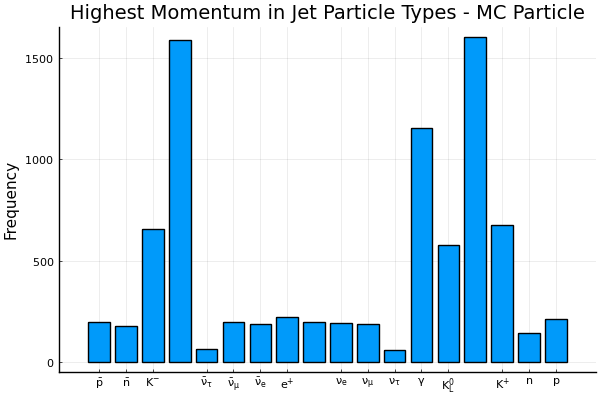

In [17]:
bb_MC_y=bb_MCleadPDG
bb_MC_u=sort(unique(bb_MC_y))
bb_MC_d=Dict([(i,count(x->x==i,bb_MC_y)) for i in bb_MC_u])
bb_MC_vals = [bb_MC_d[i] for i in bb_MC_u]
bb_MC_Names=[]
for key in bb_MC_u
    push!(bb_MC_Names, latexstring(Particle(convert(Int64, key)).latex))
end
StatsPlots.bar(bb_MC_Names, bb_MC_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - MC Particle", legend=false)

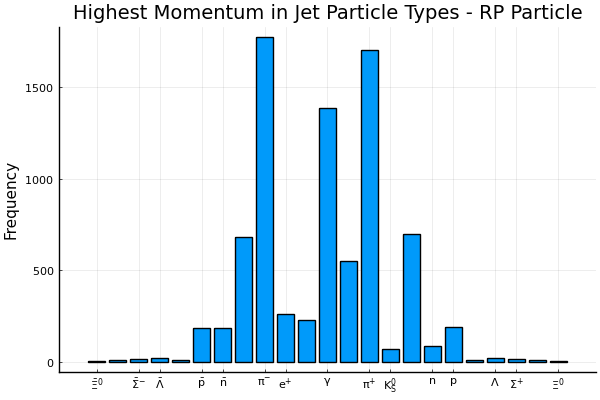

In [18]:
bb_RP_y=bb_PFOleadPDG
bb_RP_u=sort(unique(bb_RP_y))
bb_RP_d=Dict([(i,count(x->x==i,bb_RP_y)) for i in bb_RP_u])
bb_RP_vals = [bb_RP_d[i] for i in bb_RP_u]
bb_RP_Names=[]
for key in bb_RP_u
    push!(bb_RP_Names, latexstring(Particle(convert(Int64, key)).latex))
end
StatsPlots.bar(bb_RP_Names, bb_RP_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - RP Particle", legend=false)


Same code, charm events

In [19]:
LCIO.open(fileList_cc[1]) do reader
    for (iEvent, event) in enumerate(reader)
        for name in getCollectionNames(event)
            println(name)
        end
        break
    end
end

BuildUpVertices
BuildUpVertices_RP
BuildUpVertices_V0
BuildUpVertices_V0_RP
BuildUpVertices_V0_res
BuildUpVertices_V0_res_RP
BuildUpVertices_res
BuildUpVertices_res_RP
ECalBarrelHits
ECalEndcapHits
MCParticle
PandoraClusters
PandoraPFANewStartVertices
PandoraPFOs
PrimaryVertices
PrimaryVertices_RP
PrimaryVertices_res
PrimaryVertices_res_RP
RecoMCTruthLink
RefinedVertexJets
RefinedVertexJets_rel
RefinedVertexJets_vtx
RefinedVertexJets_vtx_RP
RefinedVertices
RefinedVertices_RP
VertexJets


In [20]:
cc_MCleadPDG = []
cc_MCleadingParticlePList = []
cc_PFOleadPDG = []
cc_PFOleadingParticlePList = []
cc_kShortInPiPiEventList_MC = []
cc_kShortInPiPiEventList_PFO = []
cc_lambdaInProtonEventList_MC = []
cc_lambdaInProtonEventList_PFO = []

vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)

for FILENAME in fileList_cc
    LCIO.open(FILENAME) do reader
        for (iEvent, event) in enumerate(reader)
            if iEvent>100
                break
            end
            #recoLinks = getCollection(event, "RecoMCTruthLink")
            
            #This is the Jet Clustering Loop for MCParticles
            mcp = getCollection(event, "MCParticle")
            iMCParticle = 0
            MCparticles = PseudoJet[]
            for MCparticle in mcp
                iMCParticle += 1
                if getGeneratorStatus(MCparticle) != 1
                    continue
                end
                E = getEnergy(MCparticle)
                p = getMomentum(MCparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iMCParticle)
                push!(MCparticles, pj)
            end
            MCcs = ClusterSequence(StdVector(MCparticles), jet_def)
            MCjets = exclusive_jets(MCcs, 2)
            nMCJet=0
            for j in MCjets
                nMCJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        MCParticle = mcp[index]
                        pdg=getPDG(MCParticle)
                        if abs(pdg)==13
                            continue
                        end
                        if abs(pdg)==211
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==130
                                    push!(cc_kShortInPiPiEventList_MC, iEvent)
                                end
                            end
                        end
                        if abs(pdg)==2212
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==3312
                                    push!(cc_lambdaInProtonEventList_MC, iEvent)
                                end
                            end
                        end
                        push!(cc_MCleadPDG, pdg)
                    end
                end
            end
            if FastJet.n_particles(MCcs)<0
                print("你好！")
            end
            
            #reconstructed particle loop
            rp = getCollection(event, "PandoraPFOs")
            recoLinks = getCollection(event, "RecoMCTruthLink")
            rel=LCIO.LCRelationNavigator(recoLinks)
            iRPParticle = 0
            RPparticles = PseudoJet[]
            for RPparticle in rp
                iRPParticle += 1
                #if getGeneratorStatus(RPparticle) != 1
                #    continue
                #end
                E = getEnergy(RPparticle)
                p = getMomentum(RPparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iRPParticle)
                push!(RPparticles, pj)
            end
            RPcs = ClusterSequence(StdVector(RPparticles), jet_def)
            RPjets = exclusive_jets(RPcs, 2)
            nRPJet=0
            for j in RPjets
                nRPJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        RP = rp[index]
                        mcpList = getRelatedToObjects(rel, RP)
                        if length(mcpList)>0
                            pdg=getPDG(mcpList[1])
                            if abs(pdg)==13
                                continue
                            end
                            if abs(pdg)==211
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==130
                                        push!(cc_kShortInPiPiEventList_PFO, iEvent)
                                    end
                                end
                            end
                            push!(cc_PFOleadPDG, pdg)
                            if abs(pdg)==2212
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==3312
                                        push!(cc_lambdaInProtonEventList_PFO, iEvent)
                                    end
                                end
                            end
                        end
                        #invMassRP = sqrt(getEnergy(RP)^2+leadMomentum^2)
                        #push!(PFOleadPDG, invMassRP)
                    end
                end
            end
            if FastJet.n_particles(RPcs)<0
                print("你好！")
            end
        end
    end
end

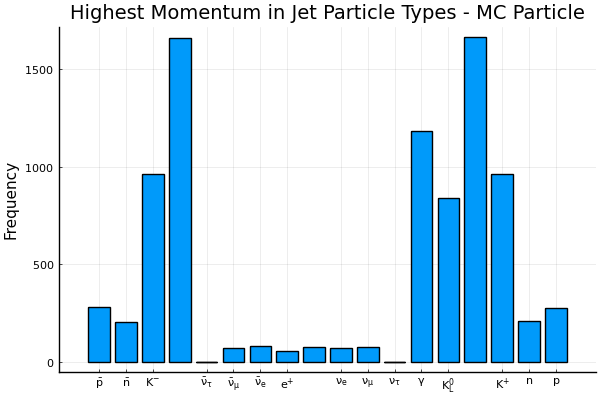

In [21]:
cc_MC_y=cc_MCleadPDG
cc_MC_u=sort(unique(cc_MC_y))
cc_MC_d=Dict([(i,count(x->x==i,cc_MC_y)) for i in cc_MC_u])
cc_MC_vals = [cc_MC_d[i] for i in cc_MC_u]
cc_MC_Names=[]
for key in cc_MC_u
    push!(cc_MC_Names, latexstring(Particle(convert(Int64, key)).latex))
end
StatsPlots.bar(cc_MC_Names, cc_MC_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - MC Particle", legend=false)

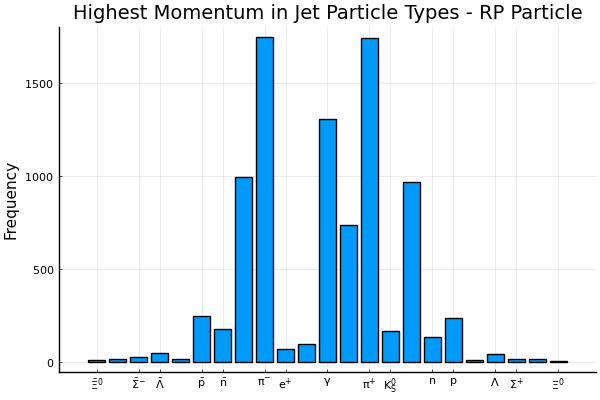

In [22]:
cc_RP_y=cc_PFOleadPDG
cc_RP_u=sort(unique(cc_RP_y))
cc_RP_d=Dict([(i,count(x->x==i,cc_RP_y)) for i in cc_RP_u])
cc_RP_vals = [cc_RP_d[i] for i in cc_RP_u]
cc_RP_Names=[]
for key in cc_RP_u
    push!(cc_RP_Names, latexstring(Particle(convert(Int64, key)).latex))
end
StatsPlots.bar(cc_RP_Names, cc_RP_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - RP Particle", legend=false)

Same code, gluon events

In [23]:
LCIO.open(fileList_gg[1]) do reader
    for (iEvent, event) in enumerate(reader)
        for name in getCollectionNames(event)
            println(name)
        end
        break
    end
end

BuildUpVertices
BuildUpVertices_RP
BuildUpVertices_V0
BuildUpVertices_V0_RP
BuildUpVertices_V0_res
BuildUpVertices_V0_res_RP
BuildUpVertices_res
BuildUpVertices_res_RP
ECalBarrelHits
ECalEndcapHits
MCParticle
PandoraClusters
PandoraPFANewStartVertices
PandoraPFOs
PrimaryVertices
PrimaryVertices_RP
PrimaryVertices_res
PrimaryVertices_res_RP
RecoMCTruthLink
RefinedVertexJets
RefinedVertexJets_rel
RefinedVertexJets_vtx
RefinedVertexJets_vtx_RP
RefinedVertices
RefinedVertices_RP
VertexJets


In [24]:
gg_MCleadPDG = []
gg_MCleadingParticlePList = []
gg_PFOleadPDG = []
gg_PFOleadingParticlePList = []
gg_kShortInPiPiEventList_MC = []
gg_kShortInPiPiEventList_PFO = []
gg_lambdaInProtonEventList_MC = []
gg_lambdaInProtonEventList_PFO = []

vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)

for FILENAME in fileList_gg
    LCIO.open(FILENAME) do reader
        for (iEvent, event) in enumerate(reader)
            if iEvent>100
                break
            end
            #recoLinks = getCollection(event, "RecoMCTruthLink")
            
            #This is the Jet Clustering Loop for MCParticles
            mcp = getCollection(event, "MCParticle")
            iMCParticle = 0
            MCparticles = PseudoJet[]
            for MCparticle in mcp
                iMCParticle += 1
                if getGeneratorStatus(MCparticle) != 1
                    continue
                end
                E = getEnergy(MCparticle)
                p = getMomentum(MCparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iMCParticle)
                push!(MCparticles, pj)
            end
            MCcs = ClusterSequence(StdVector(MCparticles), jet_def)
            MCjets = exclusive_jets(MCcs, 2)
            nMCJet=0
            for j in MCjets
                nMCJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        MCParticle = mcp[index]
                        pdg=getPDG(MCParticle)
                        if abs(pdg)==13
                            continue
                        end
                        if abs(pdg)==211
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==130
                                    push!(gg_kShortInPiPiEventList_MC, iEvent)
                                end
                            end
                        end
                        if abs(pdg)==2212
                            for parent in getParents(MCParticle)
                                if abs(getPDG(parent))==3312
                                    push!(gg_lambdaInProtonEventList_MC, iEvent)
                                end
                            end
                        end
                        push!(gg_MCleadPDG, pdg)
                    end
                end
            end
            if FastJet.n_particles(MCcs)<0
                print("你好！")
            end
            
            #reconstructed particle loop
            rp = getCollection(event, "PandoraPFOs")
            recoLinks = getCollection(event, "RecoMCTruthLink")
            rel=LCIO.LCRelationNavigator(recoLinks)
            iRPParticle = 0
            RPparticles = PseudoJet[]
            for RPparticle in rp
                iRPParticle += 1
                #if getGeneratorStatus(RPparticle) != 1
                #    continue
                #end
                E = getEnergy(RPparticle)
                p = getMomentum(RPparticle)
                pj=PseudoJet(p[1], p[2], p[3], E)
                set_user_index(pj, iRPParticle)
                push!(RPparticles, pj)
            end
            RPcs = ClusterSequence(StdVector(RPparticles), jet_def)
            RPjets = exclusive_jets(RPcs, 2)
            nRPJet=0
            for j in RPjets
                nRPJet+=1
                nCon=0
                jetTotalMomentum=(0,0,0)
                leadMomentum = 0
                for c in constituents(j)
                    nCon+=1
                    index=FastJet.user_index(c)
                    if nCon==1
                        jetTotalMomentum=jetConstituentP(c)
                    elseif nCon>1
                        jetTotalMomentum=jetTotalMomentum.+jetConstituentP(c)
                    end
                    if nCon==leadingParticleIndex(j)
                        leadMomentum = sqrt(dot((FastJet.px(c), FastJet.py(c), FastJet.pz(c)),
                            (FastJet.px(c), FastJet.py(c), FastJet.pz(c)))+10^(-10))
                        RP = rp[index]
                        mcpList = getRelatedToObjects(rel, RP)
                        if length(mcpList)>0
                            pdg=getPDG(mcpList[1])
                            if abs(pdg)==13
                                continue
                            end
                            if abs(pdg)==211
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==130
                                        push!(gg_kShortInPiPiEventList_PFO, iEvent)
                                    end
                                end
                            end
                            push!(gg_PFOleadPDG, pdg)
                            if abs(pdg)==2212
                                for parent in getParents(mcpList[1])
                                    if abs(getPDG(parent))==3312
                                        push!(gg_lambdaInProtonEventList_PFO, iEvent)
                                    end
                                end
                            end
                        end
                        #invMassRP = sqrt(getEnergy(RP)^2+leadMomentum^2)
                        #push!(PFOleadPDG, invMassRP)
                    end
                end
            end
            if FastJet.n_particles(RPcs)<0
                print("你好！")
            end
        end
    end
end

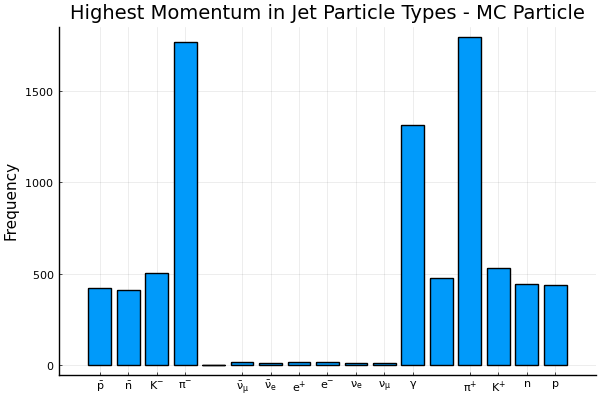

In [25]:
gg_MC_y=gg_MCleadPDG
gg_MC_u=sort(unique(gg_MC_y))
gg_MC_d=Dict([(i,count(x->x==i,gg_MC_y)) for i in gg_MC_u])
gg_MC_vals = [gg_MC_d[i] for i in gg_MC_u]
gg_MC_Names=[]
for key in gg_MC_u
    push!(gg_MC_Names, latexstring(Particle(convert(Int64, key)).latex))
end
StatsPlots.bar(gg_MC_Names, gg_MC_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - MC Particle", legend=false)

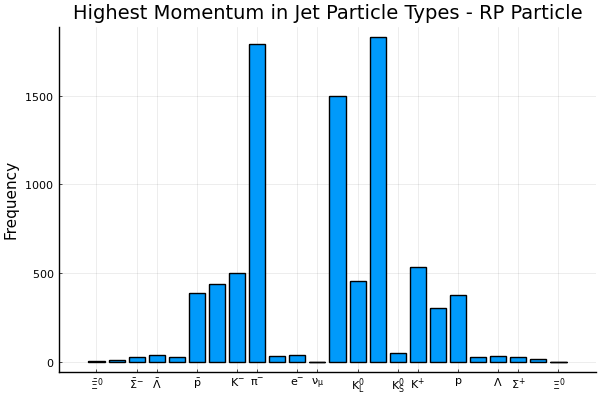

In [26]:
gg_RP_y=gg_PFOleadPDG
gg_RP_u=sort(unique(gg_RP_y))
gg_RP_d=Dict([(i,count(x->x==i,gg_RP_y)) for i in gg_RP_u])
gg_RP_vals = [gg_RP_d[i] for i in gg_RP_u]
gg_RP_Names=[]
for key in gg_RP_u
    push!(gg_RP_Names, latexstring(Particle(convert(Int64, key)).latex))
end
StatsPlots.bar(gg_RP_Names, gg_RP_vals, ylabel="Frequency", title="Highest Momentum in Jet Particle Types - RP Particle", legend=false)

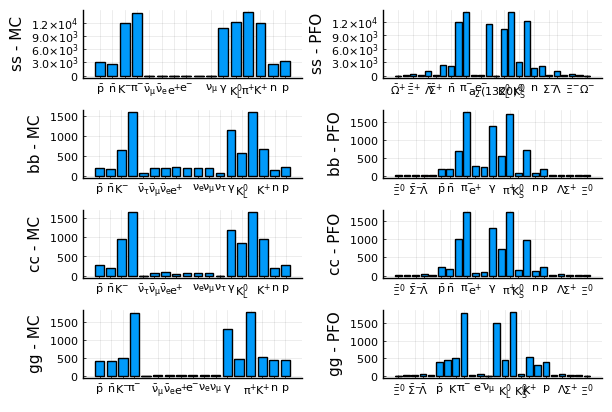

In [50]:
#plot(title="Lead Momentum Particle per Jet - MC Truth and Pandora PFO")

ss_MC_Names=[]
for key in ss_MC_u
    push!(ss_MC_Names, latexstring(Particle(convert(Int64, key)).latex))
end
ss_RP_Names=[]
for key in ss_RP_u
    push!(ss_RP_Names, latexstring(Particle(convert(Int64, key)).latex))
end
bb_MC_Names=[]
for key in bb_MC_u
    push!(bb_MC_Names, latexstring(Particle(convert(Int64, key)).latex))
end
bb_RP_Names=[]
for key in bb_RP_u
    push!(bb_RP_Names, latexstring(Particle(convert(Int64, key)).latex))
end
cc_MC_Names=[]
for key in cc_MC_u
    push!(cc_MC_Names, latexstring(Particle(convert(Int64, key)).latex))
end
cc_RP_Names=[]
for key in cc_RP_u
    push!(cc_RP_Names, latexstring(Particle(convert(Int64, key)).latex))
end
gg_MC_Names=[]
for key in gg_MC_u
    push!(gg_MC_Names, latexstring(Particle(convert(Int64, key)).latex))
end
gg_RP_Names=[]
for key in gg_RP_u
    push!(gg_RP_Names, latexstring(Particle(convert(Int64, key)).latex))
end

plot(
    StatsPlots.bar(ss_MC_Names, ss_MC_vals, ylabel="ss - MC"),
    StatsPlots.bar(ss_RP_Names, ss_RP_vals, ylabel="ss - PFO"),
    StatsPlots.bar(bb_MC_Names, bb_MC_vals, ylabel="bb - MC"),
    StatsPlots.bar(bb_RP_Names, bb_RP_vals, ylabel="bb - PFO"),
    StatsPlots.bar(cc_MC_Names, cc_MC_vals, ylabel="cc - MC"),
    StatsPlots.bar(cc_RP_Names, cc_RP_vals, ylabel="cc - PFO"),
    StatsPlots.bar(gg_MC_Names, gg_MC_vals, ylabel="gg - MC"),
    StatsPlots.bar(gg_RP_Names, gg_RP_vals, ylabel="gg - PFO"),
    layout=(4,2),
    legend=false,
    )
savefig("leadBreakdown.png")

In [28]:
cm_gg_RP=countmap(gg_RP_y)
print(minimum(gg_RP_y))
total_gg_RP=sum(cm_gg_RP[i] for i in keys(cm_gg_RP))

-3322

8461

In [29]:
cm_ss_MC=countmap(ss_MC_y)
cm_ss_RP=countmap(ss_RP_y)
cm_bb_MC=countmap(bb_MC_y)
cm_bb_RP=countmap(bb_RP_y)
cm_cc_MC=countmap(cc_MC_y)
cm_cc_RP=countmap(cc_RP_y)
cm_gg_MC=countmap(gg_MC_y)
cm_gg_RP=countmap(gg_RP_y)

Dict{Any,Int64} with 24 entries:
  310   => 50
  -11   => 31
  211   => 1830
  11    => 39
  2212  => 377
  3112  => 29
  -2212 => 389
  -211  => 1791
  130   => 458
  321   => 537
  3322  => 2
  -3122 => 41
  22    => 1497
  2112  => 305
  -3312 => 13
  -321  => 499
  3222  => 27
  -2112 => 437
  -3112 => 28
  -3322 => 3
  3122  => 33
  14    => 1
  -3222 => 28
  3312  => 16

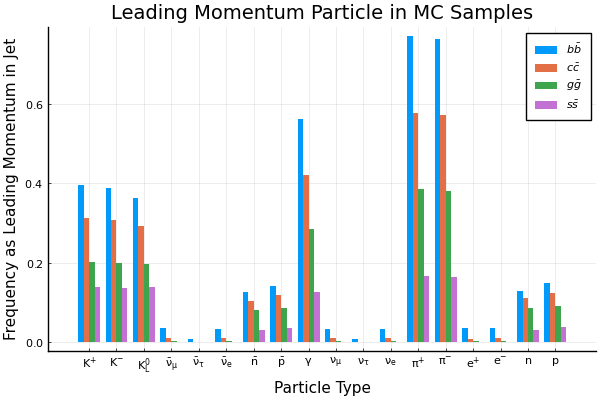

In [30]:
MC_all_values=Dict{Int, Array{Float64, 1}}()

MC_sample_list=[cm_ss_MC, cm_bb_MC, cm_cc_MC, cm_gg_MC]
RP_sample_list=[cm_ss_RP, cm_bb_RP, cm_cc_RP, cm_gg_RP]

MC_key_list=Int64[]
for sample in MC_sample_list
    for k in keys(sample)
        push!(MC_key_list, k)
    end
end

MC_key_set=Set(MC_key_list)
#print(key_set)
for key in MC_key_set
    MC_all_values[key]=Int64[]
    for sample in MC_sample_list
        total_value=0
        for sample_key in keys(sample)
            total_value+=get(sample, sample_key,  0)
        end
        push!(MC_all_values[key], get(sample, key, 0)/total_value)
    end
end

MC_grouped_data = hcat([MC_all_values[i] for i in MC_key_set]...)'
event_type =  repeat([L"$s\bar{s}$", L"$b\bar{b}$", L"$c\bar{c}$", L"$g\bar{g}$"], inner = length(MC_key_set))
MC_key_latex=[]
for key in MC_key_set
    push!(MC_key_latex, latexstring(Particle(key).latex))
end
MC_names=repeat(MC_key_latex, outer=4)
groupedbar(MC_names, MC_grouped_data, group=event_type,  #this graph isnt the input data and i have clue why
    xlabel="Particle Type", ylabel="Frequency as Leading Momentum in Jet", title="Leading Momentum Particle in MC Samples", lw=0)

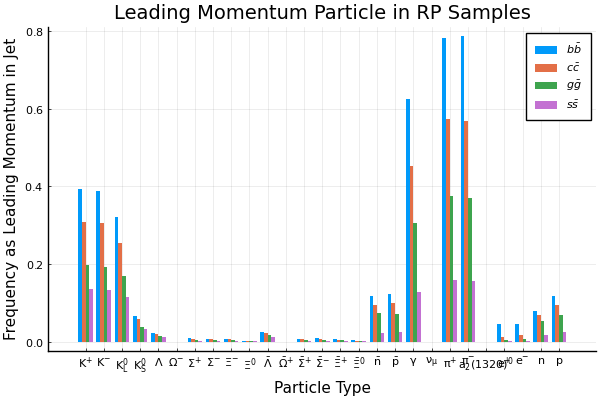

In [31]:
RP_all_values=Dict{Int, Array{Float64, 1}}()

RP_sample_list=[cm_ss_RP, cm_bb_RP, cm_cc_RP, cm_gg_RP]

RP_key_list=Int64[]
for sample in RP_sample_list
    for k in keys(sample)
        push!(RP_key_list, k)
    end
end

RP_key_set=Set(RP_key_list)
#print(key_set)
for key in RP_key_set
    RP_all_values[key]=Int64[]
    for sample in RP_sample_list
        total_value=0
        for sample_key in keys(sample)
            total_value+=get(sample, sample_key,  0)
        end
        push!(RP_all_values[key], get(sample, key, 0)/total_value)
    end
end

RP_grouped_data = hcat([RP_all_values[i] for i in RP_key_set]...)'
event_type =  repeat([L"$s\bar{s}$", L"$b\bar{b}$", L"$c\bar{c}$", L"$g\bar{g}$"], inner = length(RP_key_set))
RP_key_latex=[]
for key in RP_key_set
    push!(RP_key_latex, latexstring(Particle(key).latex))
end
RP_names=repeat(RP_key_latex, outer=4)
groupedbar(RP_names, RP_grouped_data, group=event_type, 
    xlabel="Particle Type", ylabel="Frequency as Leading Momentum in Jet", title="Leading Momentum Particle in RP Samples", lw=0)

In [47]:
#relevant_key=[130, 310, 321, -321, 3211]
relevant_key=[MC_key_list[i] for i in 9:length(MC_key_set)]
for key in relevant_key
    if key in MC_key_set
        continue
    else
        filter!(e->e≠key,relevant_key)
    end
end

print(relevant_key)

MC_dt_Names=[]
for key in relevant_key
    push!(MC_dt_Names, latexstring(Particle(key).latex))
end

pretty_table(
    hcat(
        MC_dt_Names, 
        [MC_all_values[pdg][1] for pdg in relevant_key],
        [MC_all_values[pdg][2] for pdg in relevant_key],
        [MC_all_values[pdg][3] for pdg in relevant_key],
        [MC_all_values[pdg][4] for pdg in relevant_key]),
    backend=:latex
)

[22, 2112, -321, -2112, 14, -12, -14, 12, -16, -11]\begin{tabular}{rrrrr}
\hline\hline
\textbf{Col. 1} & \textbf{Col. 2} & \textbf{Col. 3} & \textbf{Col. 4} & \textbf{Col. 5} \\\hline
$\gamma$ & 0.12484080817815717 & 0.13922372227579558 & 0.13642124668740638 & 0.16073394495412843 \\
$n$ & 0.031149967301139298 & 0.017237222757955643 & 0.024311556630948267 & 0.054434250764525995 \\
$K^{-}$ & 0.13652061175552727 & 0.07895371263259403 & 0.11072704228597764 & 0.06128440366972477 \\
$\bar{n}$ & 0.030232104544567973 & 0.021335583413693345 & 0.023505012098167993 & 0.05003058103975535 \\
$\nu_{\mu}$ & 4.589313782856618e-5 & 0.022540983606557378 & 0.008987210508123056 & 0.0009785932721712539 \\
$\bar{\nu}_{e}$ & 0.00011473284457141546 & 0.02266152362584378 & 0.009448093098283213 & 0.001345565749235474 \\
$\bar{\nu}_{\mu}$ & 4.589313782856618e-5 & 0.023987463837994213 & 0.00841110727042286 & 0.001834862385321101 \\
$\nu_{e}$ & 6.883970674284927e-5 & 0.02302314368370299 & 0.00841110727042286 & 0.0

In [46]:
#relevant_key=[130, 310, 321, -321, 3211]
relevant_key=[RP_key_list[i] for i in 19:length(RP_key_set)]
for key in relevant_key
    if key in RP_key_set
        continue
    else
        filter!(e->e≠key,relevant_key)
    end
end

print(relevant_key)

RP_dt_Names=[]
for key in relevant_key
    push!(RP_dt_Names, latexstring(Particle(key).latex))
end

pretty_table(
    hcat(
        RP_dt_Names, 
        [RP_all_values[pdg][1] for pdg in relevant_key],
        [RP_all_values[pdg][2] for pdg in relevant_key],
        [RP_all_values[pdg][3] for pdg in relevant_key],
        [RP_all_values[pdg][4] for pdg in relevant_key]),
    backend=:latex
)

[-3112, -3322, 3122, 3334, -3334, -3222, 115, 3312, 310]\begin{tabular}{rrrrr}
\hline\hline
\textbf{Col. 1} & \textbf{Col. 2} & \textbf{Col. 3} & \textbf{Col. 4} & \textbf{Col. 5} \\\hline
$\bar{\Sigma}^{+}$ & 0.00246793346539913 & 0.0012306177701206006 & 0.0015905476028175414 & 0.0033093015010046095 \\
$\bar{\Xi}^{0}$ & 0.0018481833574962095 & 0.0007383706620723603 & 0.0009088843444671666 & 0.00035456801796477955 \\
$\Lambda$ & 0.0113104394692283 & 0.002707359094265321 & 0.004658032265394229 & 0.0039002481976125754 \\
$\Omega^{-}$ & 8.853572970041723e-5 & 0.0 & 0.0 & 0.0 \\
$\bar{\Omega}^{+}$ & 2.2133932425104307e-5 & 0.0 & 0.0 & 0.0 \\
$\bar{\Sigma}^{-}$ & 0.0020695226817472527 & 0.0017228648781688408 & 0.002953874119518291 & 0.0033093015010046095 \\
$a_{2}(1320)^{0}$ & 1.1066966212552154e-5 & 0.0 & 0.0 & 0.0 \\
$\Xi^{-}$ & 0.003320089863765646 & 0.0014767413241447206 & 0.0015905476028175414 & 0.001891029429145491 \\
$K_{S}^{0}$ & 0.03364357728615854 & 0.008860447944868325 & 0.018632

fix whatever is wrong with the normalization. good nuf'\
xaxis. yup\
look at strange hadrons (k's and lambdas)\
-how many occur in each sample? yup\
-throw out events with none -> whats the efficiency? yup\ 
-look at jets: how many do we throw out if we throw out events w/out strange hadron in each jet? yup\
-relative contribution of charged kaons vs other strange hadrons\
-how effective is that?\
z finder on these files

In [34]:
function zMuonIndices(event, threshold) #for certain events it returns an empty candidatePairs
    
    iParticle = 0
    posMuonList = []
    negMuonList = []
    rp = getCollection(event, "PandoraPFOs")
    recoLinks = getCollection(event, "RecoMCTruthLink")
    rel=LCIO.LCRelationNavigator(recoLinks)
    for particle in rp
        mcp = getRelatedToObjects(rel, particle)
        if length(mcp)>0
            MCparticle=mcp[1]
        else
            continue
        end
        iParticle += 1
        if abs(getPDG(MCparticle))==13 && getGeneratorStatus(MCparticle)==1
            if getCharge(MCparticle)==1
                push!(posMuonList, (particle, iParticle))
            elseif getCharge(MCparticle)==-1
                push!(negMuonList, (particle, iParticle))
            end
        end
    end
    
    candidatePair=[]
    
    candidateDiff=91.187
    for item_pos in posMuonList    
        posParticle = item_pos[1]
        for item_neg in negMuonList
            negParticle = item_neg[1]
            if abs(91.187-invMassSum(posParticle, negParticle))<abs(candidateDiff)
                candidateDiff=91.187-invMassSum(posParticle, negParticle)
                candidatePair=[item_pos, item_neg]
            end
        end
    end
    
    if abs(candidateDiff)>threshold
        indices=[0,0]
    elseif length(candidatePair)>0
        indices = [candidatePair[1][2], candidatePair[2][2]]
    end
    return indices
end

zMuonIndices (generic function with 1 method)

In [35]:
strangeHadronPDG = [130, 310, 321, 3122]
sampleList=[fileList_ss, fileList_bb, fileList_cc, fileList_gg]

propEventsNSH=[] #NSH=no strange Hadron; only considers events if they contain k short, k long, or lambda
percentListJetHasSH = []
percentListHasJetLeaderSH = []
percentListBothJetLeaderSH = []
nStrangeHadronList=[]
recoZMuonsListPerSample = []
nEvents=[]

vp = FastJet.ValenciaPlugin(1.2, 0.8)
jet_def = JetDefinition(vp)

for fileList in sampleList
    perFilePropEventsNSH = []
    perFileJetNSH = []
    perFileEventHasJetLeaderSH=[]
    perFileEventBothJetLeaderSH=[]
    nEventsPerSampleJetsNSH=[]
    perFileHasJetLeaderSH = []
    perFileBothJetLeaderSH = []
    muonMasses=[]
    nSignal=0
    nSignalCutNSH=0
    iFile=0
    nEventsPerSampleSH=0
    nEventsPerSample=0
    for FILENAME in fileList
        iFile+=1
        LCIO.open(FILENAME) do reader
            nEventsSH=0
            nJetsNSH=0
            nEventHasJetLeaderSH=0
            nEventBothJetLeaderSH=0
            iEvent=0
            for event in reader
                zMuonIndex = zMuonIndices(event, 10)
                iEvent+=1
                nEventsPerSample+=1
                if iEvent>100
                    break
                end
                eventIsSignalNoCut=false
                eventIsSignalCutNSH=false
                eventHasSH=false
                rp = getCollection(event, "PandoraPFOs")
                recoLinks = getCollection(event, "RecoMCTruthLink")
                rel=LCIO.LCRelationNavigator(recoLinks)
                RPparticles = PseudoJet[]
                
                muon1=[]
                muon2=[]
                for (iRP, RP) in enumerate(rp)
                    E = getEnergy(RP)
                    p = getMomentum(RP)
                    pj=PseudoJet(p[1], p[2], p[3], E)
                    set_user_index(pj, iRP)
                    push!(RPparticles, pj)
                    mcp = getRelatedToObjects(rel, RP)
                    if length(mcp)>0
                        MCParticle=mcp[1]
                    else
                        continue
                    end
                    if iRP in zMuonIndex && muon1==[]
                        muon1=RP
                    end
                    if iRP in zMuonIndex && muon1!=[]
                        muon2=RP
                   end
                    if abs(getPDG(MCParticle)) in strangeHadronPDG && eventHasSH==false #&& getGeneratorStatus(MCParticle)==1 
                        eventHasSH=true
                        nEventsSH+=1
                    end
                end
                if muon1!=[] && muon2!=[]
                    push!(muonMasses, invMassSum(muon1, muon2))
                end
                nEventsSH+=0
                
                RPcs = ClusterSequence(StdVector(RPparticles), jet_def)
                RPjets = exclusive_jets(RPcs, 2)
                nRPJet=0
                jetWithoutSH = false
                aJetLeaderIsSH = false
                bothJetLeaderIsSH = false
                for j in RPjets
                    nRPJet+=1
                    nCon=0
                    aConstituentIsSH = false
                    for c in constituents(j)
                        nCon+=1
                        index=FastJet.user_index(c)
                        RP = rp[index]
                        mcpList = getRelatedToObjects(rel, RP)
                        if length(mcpList)>0
                            MCParticle = mcpList[1]
                            if abs(getPDG(MCParticle)) in strangeHadronPDG
                                aConstituentIsSH=true
                                if nRPJet==2 && nCon==leadingParticleIndex(j) && aJetLeaderIsSH==true #only can be this simple for 2 jets
                                    bothJetLeaderIsSH=true
                                end
                                if nCon==leadingParticleIndex(j)
                                    aJetLeaderIsSH=true
                                end
                            end
                        end
                            
                    end
                    if aConstituentIsSH==false
                        jetWithoutSH=true
                    end
                end
                if FastJet.n_particles(RPcs)<0
                    print("你好！")
                end
                if jetWithoutSH==true
                    nJetsNSH+=1
                end
                if aJetLeaderIsSH==true
                    nEventHasJetLeaderSH+=1
                end
                if bothJetLeaderIsSH==true
                    nEventBothJetLeaderSH+=1
                end
                nEventsSH+=0
            end
            push!(perFilePropEventsNSH, nEventsSH/iEvent)
            push!(perFileJetNSH, nJetsNSH/iEvent)
            push!(perFileEventHasJetLeaderSH, nEventHasJetLeaderSH/iEvent)
            push!(perFileEventBothJetLeaderSH, nEventBothJetLeaderSH/iEvent)
            nEventsPerSampleSH+=nEventsSH
        end
    end
    push!(propEventsNSH, mean(perFilePropEventsNSH))
    push!(percentListJetHasSH, 1-mean(perFileJetNSH))
    push!(percentListHasJetLeaderSH, mean(perFileEventHasJetLeaderSH))
    push!(percentListBothJetLeaderSH, mean(perFileEventBothJetLeaderSH))
    push!(nStrangeHadronList, nEventsPerSampleSH/iFile)
    push!(recoZMuonsListPerSample, muonMasses)
    push!(nEvents, nEventsPerSample)
end
                        
                 

In [38]:
using JLD2
@save "propEventsNSH" propEventsNSH
@save "percentListJetHasSH" percentListJetHasSH
@save "percentListHasJetLeaderSH" percentListHasJetLeaderSH
@save "percentListBothJetLeaderSH" percentListBothJetLeaderSH
@save "nStrangeHadronList" nStrangeHadronList

In [51]:
labels=[L"s\bar{s}", L"b\bar{b}", L"c\bar{c}", "gg"]
pretty_table(hcat(labels, 
        [round(i, digits=3) for i in propEventsNSH], [round(i, digits=3) for i in percentListJetHasSH]),
    ["Event Type", "No SH in Event", "No SH in Jet"], backend=:latex)
savefig("LeadBreakdownImage1")

\begin{tabular}{rrr}
\hline\hline
\textbf{Event Type} & \textbf{No SH in Event} & \textbf{No SH in Jet} \\\hline
$s\bar{s}$ & 0.974 & 0.42 \\
$b\bar{b}$ & 0.968 & 0.385 \\
$c\bar{c}$ & 0.969 & 0.397 \\
gg & 0.953 & 0.336 \\\hline\hline
\end{tabular}


In [52]:
labels=[L"s\bar{s}", L"b\bar{b}", L"c\bar{c}", "gg"]
pretty_table(hcat(labels, 
        [round(i, digits=3) for i in percentListHasJetLeaderSH], [round(i, digits=3) for i in percentListBothJetLeaderSH]),
    ["Event Type", ">0 SH is Jet Leader", "Both SH are Jet Leader"], backend=:latex)
savefig("LeadBreakdownImage")

\begin{tabular}{rrr}
\hline\hline
\textbf{Event Type} & \textbf{>0 SH is Jet Leader} & \textbf{Both SH are Jet Leader} \\\hline
$s\bar{s}$ & 0.383 & 0.025 \\
$b\bar{b}$ & 0.196 & 0.006 \\
$c\bar{c}$ & 0.278 & 0.014 \\
gg & 0.156 & 0.004 \\\hline\hline
\end{tabular}


In [64]:
labels=[L"s\bar{s}", L"b\bar{b}", L"c\bar{c}", "gg"]
table=[round(i, digits=3) for i in percentListJetHasSH]
pretty_table(hcat(labels, table), ["Event", "Jet Has SH"], backend=:latex)
#include, check if consistent w overleaf table, discuss how i include k long and compare that to jans overleaf plot

\begin{tabular}{rr}
\hline\hline
\textbf{Event} & \textbf{Jet Has SH} \\\hline
$s\bar{s}$ & 0.42 \\
$b\bar{b}$ & 0.385 \\
$c\bar{c}$ & 0.397 \\
gg & 0.336 \\\hline\hline
\end{tabular}


In [65]:
labels=[L"s\bar{s}", L"b\bar{b}", L"c\bar{c}", "gg"]
table=[round(i, digits=3) for i in percentListHasJetLeaderSH]
pretty_table(hcat(labels, table), ["Event", "A Jet Leader SH"], backend=:latex)
 #include #rerun everything w lambda included, compare again

\begin{tabular}{rr}
\hline\hline
\textbf{Event} & \textbf{A Jet Leader SH} \\\hline
$s\bar{s}$ & 0.383 \\
$b\bar{b}$ & 0.196 \\
$c\bar{c}$ & 0.278 \\
gg & 0.156 \\\hline\hline
\end{tabular}


In [66]:
labels=[L"s\bar{s}", L"b\bar{b}", L"c\bar{c}", "gg"]
table=[round(i, digits=3) for i in percentListBothJetLeaderSH]
pretty_table(hcat(labels, table), ["Event", "Both Jet Leaders SH"], backend=:latex)
#include

\begin{tabular}{rr}
\hline\hline
\textbf{Event} & \textbf{Both Jet Leaders SH} \\\hline
$s\bar{s}$ & 0.025 \\
$b\bar{b}$ & 0.006 \\
$c\bar{c}$ & 0.014 \\
gg & 0.004 \\\hline\hline
\end{tabular}


In [38]:
nEvents

4-element Array{Any,1}:
 10100
 10100
 10100
 10100

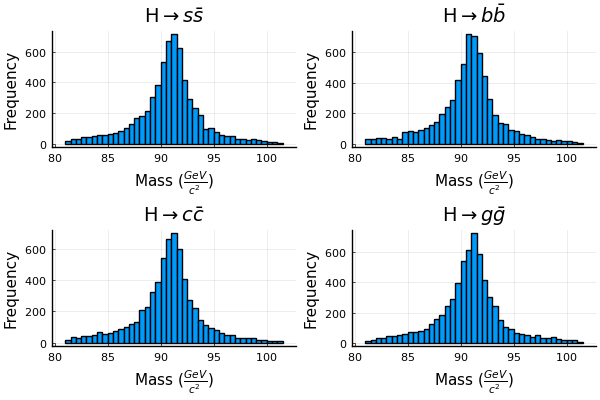

In [44]:
#how do i add one super title/xaxis/yaxis?
p1=histogram(recoZMuonsListPerSample[1], title=L"H$\rightarrow s\bar{s}$")
p2=histogram(recoZMuonsListPerSample[2], title=L"H$\rightarrow b\bar{b}$")
p3=histogram(recoZMuonsListPerSample[3], title=L"H$\rightarrow c\bar{c}$")
p4=histogram(recoZMuonsListPerSample[4], title=L"H$\rightarrow g\bar{g}$")
p5=plot(p1, p2, p3, p4, layout=(2,2))

plot(p5, 
    legend=false,
    xlabel=L"Mass ($\frac{GeV}{c^{2}}$)",
    ylabel="Frequency",
    )